# TechNova Attrition Analysis - Prédisez et comprenez le turnover des employés.

<div align="left">
  <img src="../docs/images/logo_technova.png" width="200px" alt="Logo TechNova Partners">
</div>

## **Objectif**: Identifier les causes racines de l'attrition et prédire le départ des collaborateurs à l'aide de **XGBoost** et **SHAP**.

# ⬇️ IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)

In [1]:
import pandas as pd
from pathlib import Path
from ydata_profiling import ProfileReport

# ⚙️ CONFIGURATION GLOBALE DU PROJET

In [2]:
# Configuration des chemins
RAW_DATA_DIR     = Path("../data/raw")
INTERIM_DATA_DIR = Path("../data/interim")
REPORTS_DIR      = Path("../reports")

NB_OBSERVATIONS_SIRH_RAW    = None
NB_FEATURES_SIRH_RAW        = None

NB_OBSERVATIONS_EVALS_RAW   = None
NB_FEATURES_EVALS_RAW       = None

NB_OBSERVATIONS_SONDAGE_RAW = None
NB_FEATURES_SONDAGE_RAW     = None


# Étape 1 : Analyse Exploratoire des Données (EDA)

## ❇️ LOAD AND EXPLORE DATASET

In [3]:
# 1. Chargement des fichiers
df_sirh    = pd.read_csv(RAW_DATA_DIR / "extrait_sirh.csv")
df_evals   = pd.read_csv(RAW_DATA_DIR / "extrait_eval.csv")
df_sondage = pd.read_csv(RAW_DATA_DIR / "extrait_sondage.csv")

RAW_DATASETS = {
    "SIRH"        : df_sirh,
    "Évaluations" : df_evals,
    "Sondage"     : df_sondage
}

# On garde les dimensions initials.
NB_OBSERVATIONS_SIRH_RAW,    NB_FEATURES_SIRH_RAW    = df_sirh.shape
NB_OBSERVATIONS_EVALS_RAW,   NB_FEATURES_EVALS_RAW   = df_evals.shape
NB_OBSERVATIONS_SONDAGE_RAW, NB_FEATURES_SONDAGE_RAW = df_sondage.shape

# Audit rapide des colonnes et des identifiants
print("\n==================================================================================================")
print(f"SIRH shape........: {NB_OBSERVATIONS_SIRH_RAW} employés \n")
print(f"SIRH features.....: {NB_FEATURES_SIRH_RAW}  \n")
df_sirh.info()
print("\n==================================================================================================")
print(f"EVALS shape........: {NB_OBSERVATIONS_EVALS_RAW} évaluations \n")
print(f"SIRH features......: {NB_FEATURES_EVALS_RAW}  \n")
df_evals.info()
print("\n==================================================================================================")
print(f"SONDAGE shape......: {NB_OBSERVATIONS_SONDAGE_RAW} réponses \n")
print(f"SIRH features......: {NB_FEATURES_SONDAGE_RAW}  \n")
df_sondage.info()

print("\n==================================================================================================")
print(f"TOTAL features.....: {NB_FEATURES_SIRH_RAW + NB_FEATURES_EVALS_RAW + NB_FEATURES_SONDAGE_RAW  }  \n")



SIRH shape........: 1470 employés 

SIRH features.....: 12  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null

### 🍃 Identifier le témoin pour indiquer si l’employé a quitté l’entreprise ou non.

In [4]:
HAS_LEFT = 'a_quitte_l_entreprise'

### 🔍︎ Verification & Audit. Chargement avec Pandas et vérification des types 

In [5]:
for name, df in RAW_DATASETS.items():
    print("\n==================================================================================================")
    print(f"\n--- Audit du dataset : {name} ---")
    print(f"Dimensions : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    print(f"Colonnes clés : {df.columns.tolist()[:5]}...") # Aperçu des premières colonnes
    print(df.info())                                       # Vérification des types Dtype (int, float, object)
    display(df.head(3))                                    # Visualisation des premières lignes



--- Audit du dataset : SIRH ---
Dimensions : 1470 lignes, 12 colonnes
Colonnes clés : ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_da

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0




--- Audit du dataset : Évaluations ---
Dimensions : 1470 lignes, 10 colonnes
Colonnes clés : ['satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %




--- Audit du dataset : Sondage ---
Dimensions : 1470 lignes, 12 colonnes
Colonnes clés : ['a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfa

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0


### 📊 Generer des Repport intials

In [6]:
def create_single_report(df, report_name, title, reports_dir, force_update=False):
    """
    Tâche atomique : Génère un rapport à partir d'un objet DataFrame.
    """
    reports_dir = Path(reports_dir)
    reports_dir.mkdir(exist_ok=True)
    report_path = reports_dir / f"{report_name}.html"

    if report_path.exists() and not force_update:
        print(f"✅ Rapport déjà présent : {report_name}")
        return

    print(f"🚀 Génération du rapport : {title}...")
    profile = ProfileReport(df, title=title, explorative=True, html={"style": {"full_width": True}})
    profile.to_file(report_path)
    print(f"✨ Sauvegardé : {report_path}")
    
def generate_profile_reports(file_list, raw_dir, reports_dir, force_update=False):
    """
    Genera informes de profiling para una lista de archivos CSV si no existen.
    """
    raw_dir      = Path(raw_dir)
    reports_dir  = Path(reports_dir)
    reports_dir.mkdir(exist_ok=True)

    for file_name in file_list:
            file_path = Path(raw_dir) / file_name
            if file_path.exists():
                df = pd.read_csv(file_path)
                create_single_report(
                    df, 
                    report_name=f"report_{file_path.stem}", 
                    title=f"Profiling - {file_name}", 
                    reports_dir=reports_dir, 
                    force_update=force_update
                )

FICHIERS_RAW = ["extrait_sirh.csv", "extrait_eval.csv", "extrait_sondage.csv"]
    
generate_profile_reports(
    file_list   = FICHIERS_RAW,
    raw_dir     = RAW_DATA_DIR,
    reports_dir = REPORTS_DIR
)

✅ Rapport déjà présent : report_extrait_sirh
✅ Rapport déjà présent : report_extrait_eval
✅ Rapport déjà présent : report_extrait_sondage


## 🔗 Consolidation (Merge) : Fusion des trois sources autour de l'identifiant unique de l'employé.

### 1. Nettoyage des IDs dans chaque DataFrame

In [7]:
# A. SIRH : Déjà numérique, mais nous assurons la cohérence en string
df_sirh['id'] = df_sirh['id_employee'].astype(str).str.strip()

# B. EVAL : Supprimer le préfixe 'E_'
# Nous utilisons .str.replace pour isoler le numéro
df_evals['id'] = df_evals['eval_number'].astype(str).str.replace('E_', '', regex=False).str.strip()

# C. SONDAGE : Supprimer les zéros non significatifs à gauche
# .lstrip('0') retire les '0' au début de la chaîne
df_sondage['id'] = df_sondage['code_sondage'].astype(str).str.lstrip('0').str.strip()


### 2. La Grande Fusion (The Master Merge)

In [8]:
# Fusion du SIRH avec les Évaluations
df_temp = pd.merge(df_sirh, df_evals, on='id', how='inner')

# Fusion du résultat avec le Sondage
df_merged = pd.merge(df_temp, df_sondage, on='id', how='inner')

print(f"✅ Fusion terminée. Dimensions finales : {df_merged.shape}")

✅ Fusion terminée. Dimensions finales : (1470, 35)


### 🔍︎ Verification & Audit. 

In [9]:
# Vérification immédiate
print("\n==================================================================================================")
print(f"\n--- Audit du dataset : {name} ---")
print(f"Dimensions : {df_merged.shape[0]} lignes, {df_merged.shape[1]} colonnes")
print(f"Colonnes clés : {df_merged.columns.tolist()[:5]}...") # Aperçu des premières colonnes
print(df_merged.info())                                       # Vérification des types Dtype (int, float, object)
display(df_merged.head(3))      



--- Audit du dataset : Sondage ---
Dimensions : 1470 lignes, 35 colonnes
Colonnes clés : ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_tr

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,Y,Occasionnel,0,0


### 📊 Generer un Repport sur la consolidaion

In [10]:
# 2. Générer le rapport du merge
create_single_report(
    df           = df_merged,
    report_name  = "report_FINAL_MERGED",
    title        = "Analyse Globale TechNova - Dataset Fusionné",
    reports_dir  =  REPORTS_DIR
)

✅ Rapport déjà présent : report_FINAL_MERGED


## 🔍︎ Analyse Comparative : Visualisation des segments "Restants" vs "Démissionnaires" (Attrition).

Nous devons transformer les données brutes en connaissances visuelles

### 1. Préparation de la cible (Target Cleaning)

In [11]:
# Conversion en binaire pour les calculs (1 = Parti, 0 = Resté)
df_merged['attrition_binary'] = df_merged['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})

### 2. Analyse du "Taux de Départ" (Le Chiffre Clé)

In [12]:
attrition_rate = df_merged['a_quitte_l_entreprise'].value_counts(normalize=True) * 100
print(f"Taux d'attrition global : {attrition_rate['Oui']:.2f}%")

Taux d'attrition global : 16.12%


### 3. Visualisations Comparatives (Insights)

Nous allons utiliser **Seaborn** pour comparer le profil des démissionnaires. Voici les trois graphiques indispensables :

* **A. Âge vs Attrition** : Est-ce que ce sont les jeunes qui partent ?
* **B. Salaire vs Attrition** : Le salaire est-il le facteur principal ?
* **C. Équilibre Pro/Perso vs Attrition** : La culture d'entreprise est-elle en cause ?

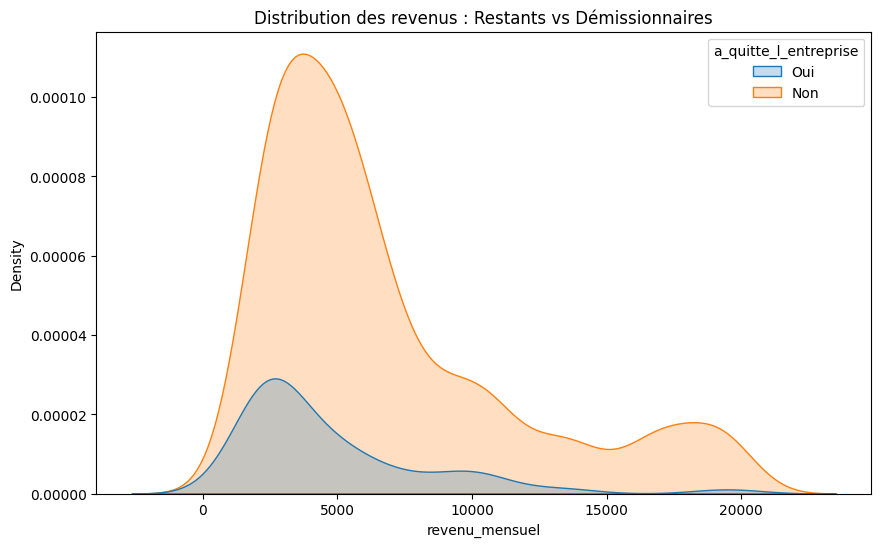

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple : Distribution du revenu mensuel par statut d'attrition
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_merged, x='revenu_mensuel', hue='a_quitte_l_entreprise', fill=True)
plt.title('Distribution des revenus : Restants vs Démissionnaires')
plt.show()

📊 Comment interpréter ton graphique ?

Voici l'analyse "Expert" de ce que tu vois :

1. **Le pic (Mode)** : On voit que pour les deux groupes, la plus grande concentration d'employés se situe autour de **2 500 - 4 000** de revenu mensuel.
2. **La queue de distribution** : Les employés qui restent ("Non") ont une courbe orange qui s'étend beaucoup plus vers la droite (les hauts salaires entre 15 000 et 20 000).
3. **L'insight critique** : La courbe bleue ("Oui") s'écrase presque totalement après 10 000. **Conclusion visuelle :** Presque personne ne démissionne chez TechNova s'il gagne plus de 10 000. L'attrition est un phénomène de "bas salaires".

Voir le nombre d employés !

Pour voir les volumes réels sur les effectifs, on utilise un Histogramme avec l'argument multiple="stack" ou element="step".

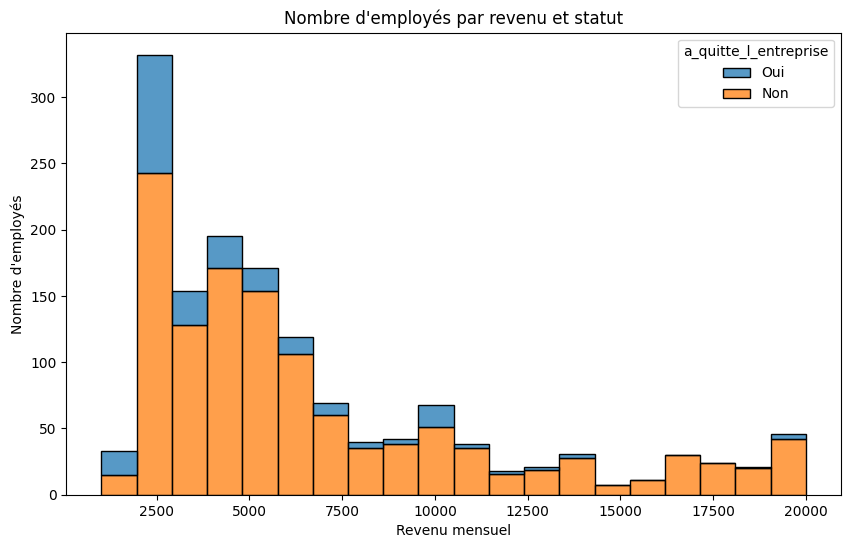

In [14]:

plt.figure(figsize=(10, 6))
# On utilise histplot au lieu de kdeplot
sns.histplot(data=df_merged, x='revenu_mensuel', hue='a_quitte_l_entreprise', 
             multiple="stack", palette="tab10")

plt.title('Nombre d\'employés par revenu et statut')
plt.ylabel('Nombre d\'employés')
plt.xlabel('Revenu mensuel')
plt.show()

## 🚀 Dernière étape de l'EDA : Sauvegarde du Master Dataset
Une fois que on a exploré visuellement vos données, il faut figer ce travail :

In [16]:
# Sauvegarde dans data/interim avant le Feature Engineering (Étape 2)
df_merged.to_parquet(INTERIM_DATA_DIR / "df_merged_eda.parquet")

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.